### Extract daily precipitation by pasture at CPER
Uses pre-processed, interpolated/kriged daily precipitation rasters produced from the ground sensor network (preprocessing was 
done using a separate R script). Computes the mean of all grid cells within each pasture. Returns a .csv file with a single precipitation value for each date for each pasture.

In [1]:
import rioxarray as riox
import rasterio as rio
import xarray as xr
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from hlsstack.hls_funcs.masks import shp2mask
from tqdm.notebook import tqdm
import glob

In [2]:
# dask cluster location
cluster_loc = 'local'

# the respective generic paths for LMF and HLS pre-processed data
precip_path = '/mnt/t/3-GIS/CPER/Layers/Precipitation/cper_ppt_interp/cper_ppt_interp_daily_wy_{}.tif'

# the path to a shapefile with CPER pasture boundaries
cper_f = '../data/ground/boundaries/cper_pastures_2017_dissolved.shp'

# the range of years to be processed
yrs = range(2019, 2023)

# the output path for the csv file
out_f = '/mnt/t/3-GIS/CPER/Layers/CPER_RS_avgs/cper_precip_means_wy_2019_2022.csv'

In [3]:
# setup the dask cluster
if cluster_loc == 'local':
    #os.chdir(wkDIR)
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
    inDIR = 'data/'

   setting up Local cluster...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 11.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35851,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 11.85 GiB
Comm: tcp://127.0.0.1:46607,Total threads: 2
Dashboard: http://127.0.0.1:45413/status,Memory: 1.48 GiB
Nanny: tcp://127.0.0.1:39023,


In [4]:
# prepare the pasture boundaries to be converted into an xarray mask
cper = gpd.read_file(cper_f).to_crs(32613)
cper_info = cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
past_dict[0] = 'UNK'
cper_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]

In [40]:
yr = 2019
# define file path
fpath = precip_path.format(str(yr))
# read in data
da = riox.open_rasterio(fpath, masked=True)
# rename band for converting to date
da = da.rename({'band': 'date'})
# convert band number to a date
da['date'] = [datetime(yr, 10, 1).date() + timedelta(days=int(x-1)) for x in da.date.values]
# convert to dataset
ds = da.to_dataset(name='ppt_mm')
# reproject if necessary
if ds.rio.crs != cper.crs:
    ds = ds.rio.reproject(cper.crs)

# subset to only CPER boundaries
ds = ds.sel(x=slice(cper.total_bounds[0], cper.total_bounds[2] + 30),
            y=slice(cper.total_bounds[3], cper.total_bounds[1] - 30))
# create the pasture mask from shapefile
cper_mask = shp2mask(shp=cper_mask_shp, 
                     transform=ds.rio.transform(), 
                     outshape=ds['ppt_mm'].shape[1:], 
                     xr_object=ds['ppt_mm'])
# convert from numeric id's to pasture names
past_mask = np.array([past_dict[i] for i in cper_mask.values.flatten()]).reshape(cper_mask.shape)
# add the pasture mask to the NDVi dataset
ds = ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
ds = ds.set_coords('Pasture')
# get pasture means and convert to dataframe
df_yr = ds.groupby(
    ds['Pasture']).mean(
    dim='stacked_y_x').to_dataframe().reset_index().drop(
    columns='spatial_ref')
df_yr['WaterYear'] = str(yr)

In [41]:
df_yr

,date,Pasture,ppt_mm,WaterYear
0,2019-10-01,10SNE,0.006647,2019
1,2019-10-01,11NS,0.014543,2019
2,2019-10-01,11NW,0.009603,2019
3,2019-10-01,12C,0.066357,2019
4,2019-10-01,12NE,0.041618,2019
...,...,...,...,...
20435,2020-09-29,Saltflat,0.000000,2019
20436,2020-09-29,Slayton,0.000000,2019
20437,2020-09-29,Snowfence,0.000000,2019
20438,2020-09-29,South,0.000000,2019


In [6]:
# loop through each year and extract pasture NDVI means for each date
for idx, yr in enumerate(tqdm(yrs)):
    # define file path
    fpath = precip_path.format(str(yr))
    # read in data
    da = riox.open_rasterio(fpath, masked=True)
    # rename band for converting to date
    da = da.rename({'band': 'date'})
    # convert band number to a date
    da['date'] = [datetime(yr-1, 10, 1).date() + timedelta(days=int(x-1)) for x in da.date.values]
    # convert to dataset
    ds = da.to_dataset(name='ppt_mm')
    # reproject if necessary
    if ds.rio.crs != cper.crs:
        ds = ds.rio.reproject(cper.crs)

    # subset to only CPER boundaries
    ds = ds.sel(x=slice(cper.total_bounds[0], cper.total_bounds[2] + 30),
                y=slice(cper.total_bounds[3], cper.total_bounds[1] - 30))
    # create the pasture mask from shapefile
    cper_mask = shp2mask(shp=cper_mask_shp, 
                         transform=ds.rio.transform(), 
                         outshape=ds['ppt_mm'].shape[1:], 
                         xr_object=ds['ppt_mm'])
    # convert from numeric id's to pasture names
    past_mask = np.array([past_dict[i] for i in cper_mask.values.flatten()]).reshape(cper_mask.shape)
    # add the pasture mask to the NDVi dataset
    ds = ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
    ds = ds.set_coords('Pasture')
    # get pasture means and convert to dataframe
    df_yr = ds.groupby(
        ds['Pasture']).mean(
        dim='stacked_y_x').to_dataframe().reset_index().drop(
        columns='spatial_ref')
    df_yr['WaterYear'] = str(yr)
    
    # create the initial output dataframe if it doesn't exist
    if idx == 0:
        df_out = df_yr.copy()
    # append to the existing output dataframe
    else:
        df_out = pd.concat([df_out, df_yr])

  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
# quality control check that all pastures are present for each year
df_out.groupby('WaterYear').apply(lambda x: len(x['Pasture'].unique()))

WaterYear
2019    56
2020    56
2021    56
2022    56
dtype: int64

In [8]:
# preview the output dataframe
df_out

,date,Pasture,ppt_mm,WaterYear
0,2018-10-01,10SNE,0.006647,2019
1,2018-10-01,11NS,0.014543,2019
2,2018-10-01,11NW,0.009603,2019
3,2018-10-01,12C,0.066357,2019
4,2018-10-01,12NE,0.041618,2019
...,...,...,...,...
20435,2022-09-30,Saltflat,6.654120,2022
20436,2022-09-30,Slayton,4.750357,2022
20437,2022-09-30,Snowfence,5.874794,2022
20438,2022-09-30,South,5.378066,2022


In [9]:
# write the output dataframe to disk
df_out.to_csv(out_f, index=False)

#### Plot saved results

In [47]:
import seaborn as sns

In [48]:
# read in the saved .csv output
df_saved = pd.read_csv(out_f)

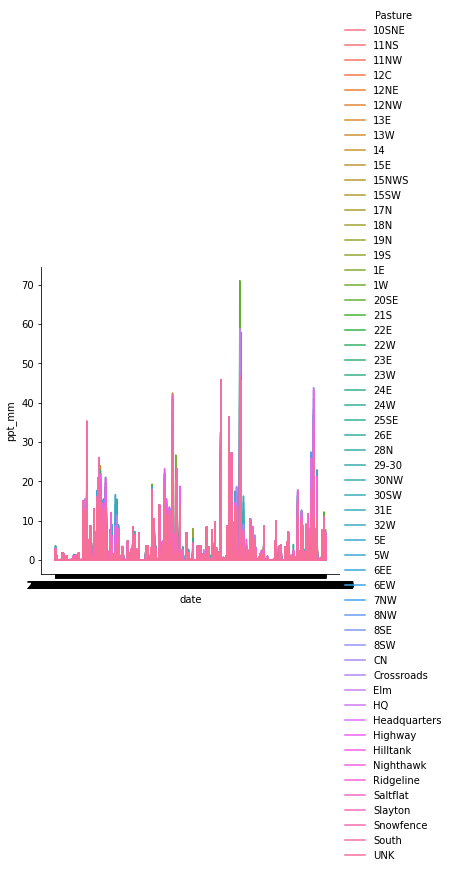

In [49]:
# plot all pastures and all dates on a single figure
sns.relplot(data=df_saved, x='date', y='ppt_mm', hue='Pasture', kind="line", errorbar=None)